<a href="https://colab.research.google.com/github/KOdin2/machine_learning/blob/main/Adaboost_assessment_with_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Adaboost**

This code up is used to classify a dataset whose labels are a binary (either 1 and 0) a range of hyperparameters are tried. The best hyperparameters are used to calculate the Gini importance of each feature. The Gini importance allows us to remove features with a rank of 0, which means the model does not find it useful.

**Note:** A uploaded dataset must have one column labeled "Label" with the row values as a 1 or 0 otherwise this code will not work

In [1]:
""" Import libraries """
import matplotlib.pyplot as plt
import numpy as np
import io
import pandas as pd
import sklearn
import csv


""" Import sklearn specific functions """
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

""" Import excel writer to allow excel notebooks to be written """
!pip install xlsxwriter
import xlsxwriter

     |████████████████████████████████| 149 kB 13.6 MB/s 


The following code is used to upload as many files as you want to be classified

In [2]:
from google.colab import files
uploaded = files.upload()

Saving SSteel_25-75WF_dataset_updated.csv to SSteel_25-75WF_dataset_updated.csv


The best measurements to use for classification are:

* precision
* recall
* accuracy
* f1
* roc_auc

Be careful with precision and recall as you can achieve 100% of one and have a really low other. F1 score is the harmoninc mean of precision and recall therefore should be used instread

**testing_combination_arrays**

Used to create a list of different number of estimators used by adaboost which is timed by 10

**calculate_cross_validation_value**

Is used to fond the largest fold value possible for CV 

In [3]:
def testing_combination_arrays(max_varible):

  varible_combinations = []
  """ Create a list of maxvaible length where the values are *10 """
  b = 1
  for value in range(0, max_varible):
    varible_combinations.append(int(b*10) )
    b+=1

  return varible_combinations


def calculate_cross_validation_value(y_train):
  """ aqurie the smallest number group of labels and return this for CV """
  arr = y_train.to_numpy()
  bin_arr = np.bincount(arr)
  return bin_arr.min()

**grid_search_RF_function**

This function is used to perfrom a grid search of defined hyperparameters

Once complete this model will the models best parameters

In [4]:
def grid_search_function(x_train, y_train, Varible_list_1 , number_of_cv_folds):

  """ Initalise the adaboost model with the best hyperparameters and setup the MinMaxscaler() """
  model = AdaBoostClassifier(random_state=0)  
  min_max = MinMaxScaler()
  
  """ Setup the pipeline to perform scaling and model """
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  """ Set up the parameters for grid search with desired varibles for it to try """
  param_grid = [
      {'model__n_estimators': Varible_list_1,}
  ]

  """ Assign the scoring type for grid search """
  scoring_type = 'f1'
  
  """ Set up the gridsearch using defined varible """
  grid_search = GridSearchCV(estimator= pipe, param_grid= param_grid,  cv= number_of_cv_folds , scoring=scoring_type,  return_train_score=True, n_jobs=-1) #n_jobs=-1 will use all avaliable processors avaliable

  """ Perfrom grid search with the x and y train data """
  grid_search.fit(X= x_train, y= y_train)

  """ Aquire the best score and round to 4 decimal places and print the best parameters"""
  best_accuracy = round(grid_search.best_score_,4)
  print("[INFO] Best score: " + str(best_accuracy) + " with parameters: "  + str(grid_search.best_params_) )

  """ Create a list of the best results from the Gridsearch """
  best_model_details = ([ "Adaboost",
                        scoring_type,
                        best_accuracy,
                        grid_search.best_params_['model__n_estimators'],
                        str(number_of_cv_folds.n_splits),
                      
  ])

  """ Resturn the best model results and the parameters that will be used for feature reduction """ 
  return best_model_details, grid_search.best_params_

**graph_important_features** 

Is used to graph the importance of the features

As it is a function the values can be changed to make the graph clear.

In [5]:
def graph_important_features(model, x_train_df):

  print("Feature importances of the input data obtained from (feature_importances_) for adaboost")

  importance = np.abs(model.feature_importances_)
  feature_names = np.array(x_train_df.columns)

  f, ax = plt.subplots(figsize=(30,5))
  plt.bar(height=importance, x=feature_names, )

  plt.xticks(rotation='vertical', fontsize = 16)
  plt.yticks(fontsize = 16)

  plt.xlabel("Feature", fontsize = 20)
  plt.ylabel("Gini importance", fontsize = 20)

  plt.show()


**reduce_input**

This code uses the best model paramters from the grid search to calculate the Gini importance of each feature

Once the Gini importace is calucalte any features with an importance of 0 is removed

The function then returns the reduced dataset

If no features are removed the function returns true, ending the while loop which reduces the number of inputs

**best_model_test**

THis functions uses the best hyperparameters and the reduced dataset to perform cross validation.

This function then returns the results and are used as the final result

In [6]:
def reduce_input(x_train, y_train, number_of_cv_folds, best_paramater):

  """ Initalise the adaboost model with the best hyperparameters and setup the MinMaxscaler() """
  model = AdaBoostClassifier(random_state=0, n_estimators = best_paramater['model__n_estimators'])  
  min_max = MinMaxScaler()
  
  """ Setup the pipeline to perform scaling and model """
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )                               
  ])


  """ Fit the pipeline with the train data """
  pipe = pipe.fit(x_train, y_train)

  """ Create a copy of the x train dataframe """  
  updated_x_train = x_train.copy()

  """ Loop through all feature importance values and remove any featues with a value of 0 from the updated dataframe"""
  bad_inputs = 0
  for index, Gini_value in enumerate(model.feature_importances_):
    
    if(Gini_value == 0):
      updated_x_train = updated_x_train.drop([x_train.columns[index]], axis='columns')
      bad_inputs +=1

  """ Check to see how many features are removed, if 0 then assign end_of_reduction to True to stop the input reduction method """
  if(bad_inputs==0):
    print("[INFO] Inputs cannot be further reduced!")
    end_of_reduction = True
  else: 
    print("[INFO] Number of removed inputs: " + str(bad_inputs))
    end_of_reduction = False
  
  """ Plot a bar chart of the importantance of each features """
  graph_important_features(model, x_train)

  """ return status True if featrue reduction can no longer happen and the updated x_train dataset"""
  return end_of_reduction, updated_x_train



def best_model_test(x_train, y_train, number_of_cv_folds, best_paramater):

  """ Initalise the adaboost model with the best hyperparameters and setup the MinMaxscaler() """
  model = AdaBoostClassifier(random_state=0, n_estimators = best_paramater['model__n_estimators'])  
  min_max = MinMaxScaler()
  
  """ Setup the pipeline to perform scaling and model """
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  """ Use cross_val_predict to perform cross validation and get the predicted labels """
  y_train_pred = cross_val_predict(pipe, x_train, y_train, cv=number_of_cv_folds)

  """ Use the labels to produce a confusion matrix """
  conf = confusion_matrix(y_train, y_train_pred)
  print(conf)

  """ Calcualte the accuracies to .4dp which are then printed"""
  f1        = round(f1_score(y_train, y_train_pred), 4)
  precision = round(precision_score(y_train, y_train_pred), 4)
  recall    = round(recall_score(y_train, y_train_pred), 4)

  print("F1 score\tPurity\t\tRecovery")
  print(str(f1) + "\t\t" + str(precision) + "\t\t" + str(recall) + "\n\n")
    
  """ Write the actual labels and predicted labels to a list. Work out whether the preidction was correct, if so write correct. This is for easy reference """
  predictions_vs_acutal = []
  for index, row_data in enumerate(y_train):  
      if y_train[index] == y_train_pred[index]:
        correct_str = "Correct"
      else:
        correct_str = "Incorrect"
      predictions_vs_acutal.insert(index, [y_train[index], y_train_pred[index], correct_str]   )


  """ Create a list that has the accuracy results of the best model """
  model_check = ([str(f1), str(precision), str(recall), str(conf), str(len(x_train.columns)),  str(number_of_cv_folds.n_splits)])


  return predictions_vs_acutal, model_check

Headers used for the exported CSV file

In [7]:
def write_results_to_excel (file_name, grid_search_list, model_check, best_features, predictions_vs_acutal):

  """ Create headers used for the output file """
  header = ["Algorithm", "Scoring type", "Score", "Number of esitmators",  "Max features", "Stratified KFold splits"]
  model_check_header = ["F1 score", "Purity", "Recovery", "Confusion matrix", "Number of inputs", "Stratified KFold splits"]
  predicion_header = ["Label" , "Prediction", "Result"]

  """Create the workbook """
  workbook = xlsxwriter.Workbook(str(file_name) + '_adaboost.xlsx')
  worksheet = workbook.add_worksheet("Adaboost")

  """ Wrtie the Grid search results """
  worksheet.write(0, 0, "Grid search results")
  for row_num, row_data in enumerate(header):
    worksheet.write(1, row_num, row_data) 
  row = 2
  for row_num, row_data in enumerate(grid_search_list):
      for col_num, col_data in enumerate(row_data):
          worksheet.write(row, col_num, str(col_data))
      row+=1
  row+=1

  """ Write the best model results for final CV test with reduced dataset"""
  worksheet.write(row, 0, "Best model testing result")
  row+=1
  for row_num, row_data in enumerate(model_check_header):
    worksheet.write(row, row_num, row_data)
  row +=1
  for row_num, row_data in enumerate(model_check):
    worksheet.write(row, row_num, row_data) 
  row +=2

  """ Write all important features"""
  worksheet.write(row, 0, "Imporant Features")
  row +=1
  for row_num, row_data in enumerate(best_features):
      for col_num, col_data in enumerate(row_data):
          worksheet.write(row, col_num, str(col_data))
      row+=1

  row+=1
  """ Write the predicted values againest actual """
  worksheet.write(row, 0, "Prediction results for the best model")
  row +=1 
  for row_num, row_data in enumerate(predicion_header):
    worksheet.write(row, row_num, row_data) 
  row+=1

  for row_num, row_data in enumerate(predictions_vs_acutal):
      for col_num, col_data in enumerate(row_data):
          worksheet.write(row, col_num, str(col_data))
      row+=1

  """ Close the workboot and download"""
  workbook.close()
  files.download(str(file_name) + '_adaboost.xlsx') 


[INFO] CODE START
[INFO] File uploaded: SSteel_25-75WF_dataset_updated.csv
[INFO] Number of CV folds: 14
[INFO] N_estimators combinations: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[INFO] Finding best model parameters
[INFO] Best score: 0.9286 with parameters: {'model__n_estimators': 30}
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 65
Feature importances of the input data obtained from (feature_importances_) for adaboost


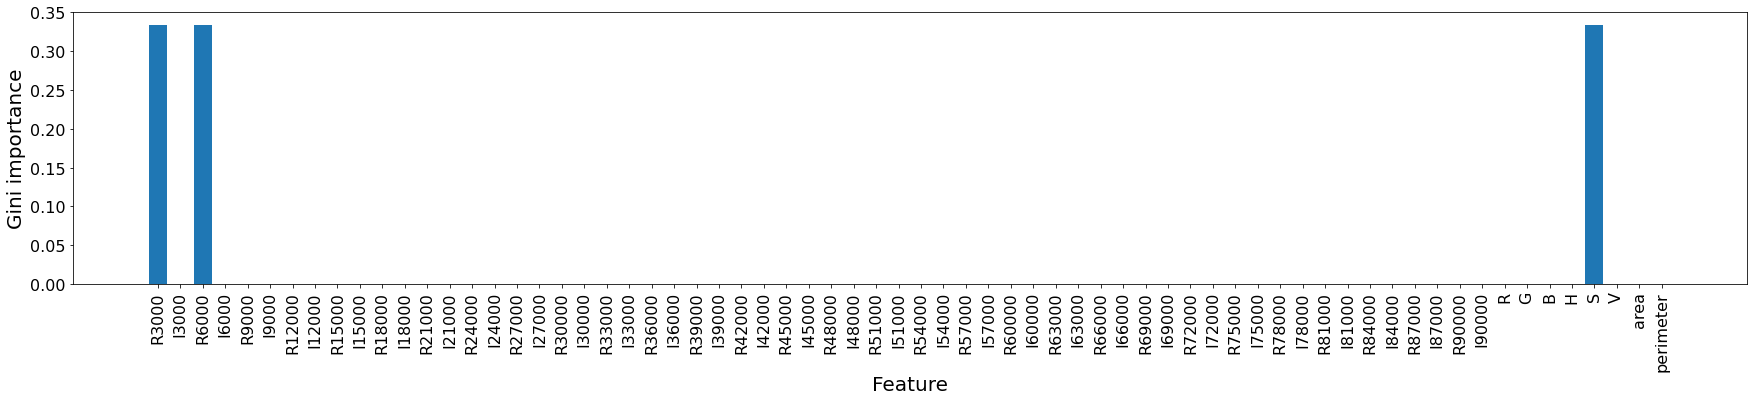

[INFO] Finding best model parameters
[INFO] Best score: 0.9286 with parameters: {'model__n_estimators': 30}
[INFO] Reducing input data based on best model
[INFO] Inputs cannot be further reduced!
Feature importances of the input data obtained from (feature_importances_) for adaboost


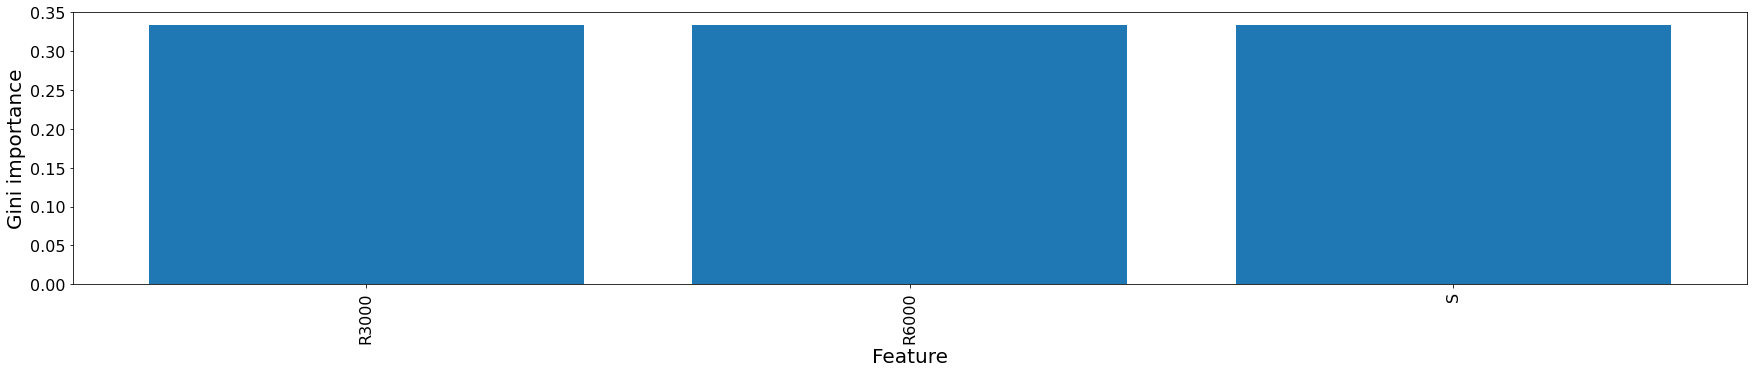

[INFO] Final cross-fold valudation test using the reduced input data and best parameters
[[24  3]
 [ 0 14]]
F1 score	Purity		Recovery
0.9032		0.8235		1.0




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
print("[INFO] CODE START")

""" Loop through all uploaded files"""
for file_name in uploaded:
    grid_search_list = []  
    best_features = []
    reduction_mode = False

    """ Convert the uploaded .csv file to a dataframe """
    print("[INFO] File uploaded: " +str(file_name))
    loaded_file = pd.read_csv(io.BytesIO(uploaded[file_name]))

    """ Create the x and y train datasets"""
    x_train  = loaded_file.drop(['Label'], axis='columns')
    y_train     = loaded_file.Label

    """ Calculate the largest of number of fold for StratifiedKfold cross-vaildation"""
    number_of_cv_folds = StratifiedKFold(calculate_cross_validation_value(y_train)) #This function can be changed to a int if a dataset is large as it will take long to run, e.g. 10
    print("[INFO] Number of CV folds: " + str(number_of_cv_folds.n_splits))

    """ Calculate and create a list of the different varibles for the GridSearchCV, it takes the x train and the max value for max features"""
    n_estitmators_var = testing_combination_arrays(20) #This function can be removed and a manualy written list can be used instead
    print("[INFO] N_estimators combinations: " + str(n_estitmators_var))

    """ Stay in a while loop while in inputs are reduced, if the inputs cannot be reduced any further break the loop """
    while(reduction_mode==False):

      """ Perform Gird search for the best hyperparameters and appended results to a list"""
      print("[INFO] Finding best model parameters")
      grid_search_result, best_paramater = grid_search_function(x_train, y_train, n_estitmators_var, number_of_cv_folds)   
      grid_search_list.append(grid_search_result)

      """ Reduce the inputs of the x train dataset using the Gini importance and append the best features to a list"""
      print("[INFO] Reducing input data based on best model")
      reduction_mode, x_train = reduce_input(x_train, y_train, number_of_cv_folds, best_paramater)
      best_features.append(x_train.columns)

    """ Using the best parameters and reduced dataset aquire the accuracy results and preductions """
    print("[INFO] Final cross-fold valudation test using the reduced input data and best parameters")
    predictions_vs_acutal, model_check = best_model_test(x_train, y_train, number_of_cv_folds, best_paramater,)
    
    """ Write all the results of the .csv file to an excel work book """
    write_results_to_excel(file_name, grid_search_list, model_check, best_features, predictions_vs_acutal)  
